In [20]:
import control as ct
import numpy as np
import control.optimal as opt
import matplotlib.pyplot as plt

In [21]:
Ts = 1

In [59]:
A = [[1, Ts],
     [0,  1]]

B = [[-1/2*Ts*Ts],
     [-Ts]]

modelMPC = ct.ss2io(ct.ss(A, B, np.eye(2), 0, Ts))

Q = modelMPC.C.transpose() @ np.diag([10, 10]) @ modelMPC.C
R = np.array([5])
cost = opt.quadratic_cost(modelMPC, Q, R)

horizon = np.arange(0, 100) * Ts
x0 = [100, 0]
constraints = [opt.input_range_constraint(modelMPC, -1.0, 1.0)]
               # opt.state_range_constraint(modelMPC, [5, -40], [np.inf, 40])
ctrl = opt.create_mpc_iosystem(modelMPC, horizon, cost, constraints)

result = opt.solve_ocp(
    modelMPC, horizon, x0, cost, constraints,
    options={'eps': 0.01})    # set step size for gradient calculation

Summary statistics:
* Cost function calls: 937
* Constraint calls: 1048
* System simulations: 1947


[[ 0.84115566  0.76268644  0.68773282  0.6162923   0.54835785  0.48391931
   0.42295987  0.36885258  0.24857685  0.17427626  0.06944503  0.02539119
  -0.01542886 -0.05307684 -0.08762242 -0.11913828 -0.16270995 -0.18997557
  -0.21289801 -0.23313645 -0.25079039 -0.2659605  -0.27875212 -0.29366239
  -0.30230865 -0.3086571  -0.32248207 -0.32503795 -0.32149734 -0.32270902
  -0.32291818 -0.31933003 -0.31448856 -0.24532337 -0.21619494 -0.20824595
  -0.19946856 -0.18052561 -0.11176086 -0.10107084 -0.08992221 -0.07839989
  -0.06658626 -0.05456055 -0.0423989  -0.0301738  -0.01795398 -0.00580513
   0.00621087  0.01803579  0.04116258  0.05746968  0.06840774  0.07895713
   0.09799214  0.10818082  0.1173369   0.12596453  0.1340375   0.14153353
   0.14843339  0.15472068  0.12798486  0.09734715  0.10172408  0.10545186
   0.10853051  0.11096533  0.11276466  0.11394022  0.11450736  0.11448437
   0.11389256  0.1127557   0.02581057  0.02366628  0.02106388  0.01803701
   0.0146212   0.01085419  0.00677541 

Text(0, 0.5, 'u')

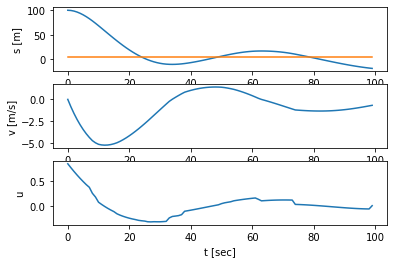

In [60]:
u = result.inputs
print(u)
t, y = ct.input_output_response(modelMPC, horizon, u, x0)

# Plot the results
plt.subplot(3, 1, 1)
plt.plot(t, y[0])
plt.plot([0,horizon[-1]], [5,5])
plt.xlabel("t [sec]")
plt.ylabel("s [m]")

plt.subplot(3, 1, 2)
plt.plot(t, y[1])
plt.xlabel("t [sec]")
plt.ylabel("v [m/s]")

plt.subplot(3, 1, 3)
plt.plot(t, u[0])
plt.xlabel("t [sec]")
plt.ylabel("u")

In [24]:
%%capture --no-display
# the code tries to implement an RL agent to the cruise-ctrl-v0 env 
from cProfile import label
from distutils.log import info
from math import dist
from turtle import color
import gym 
import gym_cruise_ctrl
import matplotlib.pyplot as plt
import numpy as np
from toc import OneDTimeOptimalControl

from stable_baselines3 import PPO, A2C, SAC

env = gym.make('cruise-ctrl-v0')

model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps = 10**5)
# model.save("saved_models/SAC_cruise_ctrl") 
model = SAC.load("../saved_models/SAC_cruise_ctrl")

"""
### Initialize time optimal controller
"""
toc = OneDTimeOptimalControl(*env.GetTOCInitParams())

"""
### Validate results
"""
total_reward_list = [0]
rel_dist_list = []
fv_pos_list = []
ego_pos_list = []
action_list = []

obs = env.reset()

while True:
    # action, _ = model.predict(obs)
    
    result = opt.solve_ocp(modelMPC, horizon, obs - np.array([50,0]), cost, constraints, options={'eps': 0.01})
    action = np.array([result.inputs[0,0]])
    # action = np.clip(action, -1, 1)
    
    # ego_state = env.GetEgoVehicleState()
    # action = np.array([toc.action(ego_state[1], obs[0])])
    # action = np.array([toc.action(obs[1], obs[0])])
    
    obs, reward, done, info = env.step(action)
    # env.render()

    # Gather results for plotting
    action_list.append(action)
    total_reward_list.append(total_reward_list[-1] + reward)
    rel_dist_list.append(obs[0])
    fv_pos_list.append(info["fv_pos"])
    ego_pos_list.append(info["ego_pos"])

    
    if done:
        break

del total_reward_list[0]
# env.close() 


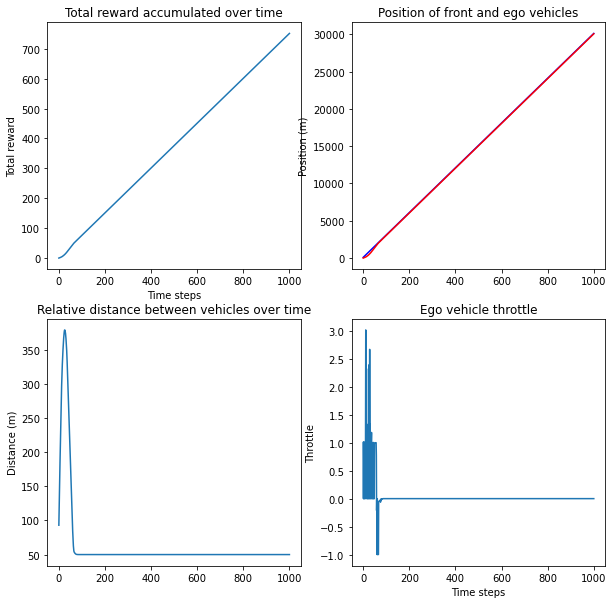

In [25]:
"""
### Generate Plots
"""
# print(total_reward_list)
# print(rel_dist_list)
# print(fv_pos_list)
# print(ego_pos_list)
fig, axes = plt.subplots(2,2, figsize = (10,10))

axes[0,0].plot(total_reward_list)
axes[1,0].plot(rel_dist_list)
axes[0,1].plot(fv_pos_list, color = 'b', label = 'Front vehicle')
axes[0,1].plot(ego_pos_list, color = 'r',  label = 'Ego vehicle')
axes[1,1].plot(action_list)

axes[0,0].title.set_text('Total reward accumulated over time')
axes[1,0].title.set_text('Relative distance between vehicles over time')
axes[0,1].title.set_text('Position of front and ego vehicles')
axes[1,1].title.set_text('Ego vehicle throttle')

axes[0,0].set_xlabel('Time steps')
axes[1,1].set_xlabel('Time steps')

axes[0,0].set_ylabel('Total reward')
axes[1,0].set_ylabel('Distance (m)')
axes[0,1].set_ylabel('Position (m)')
axes[1,1].set_ylabel('Throttle')

plt.legend
plt.show()

In [26]:
obs

array([5.0000000e+01, 7.6293945e-06], dtype=float32)